<center><h1>DSCI-552 FINAL PROJECT</h1>
<br>
<font size="3">Name: Vorapoom Thirapatarapong</font>
<br>
<font size="3">USC ID: 4397330150 Github Username: bvorapoom</font></center>

> <b>references:</b><br>
reference of resources used for the project is mainly from Keras documentation (https://keras.io/api/).  The idea of removing stop words to improve sentiment analysis performance is from reading the article on analyticsvidhya (https://www.analyticsvidhya.com/blog/2015/10/6-practices-enhance-performance-text-classification-model/). Several coding issues solved by looking at several blogs on stackoverflow (e.g. https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do, https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape)

#### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import os
import re
import nltk
from nltk.corpus import stopwords

# 1. Text Classification

#### import data (positive: y = 1, negative: y = -1)

In [2]:
# import all data to dataframe

# import negative reviews
path_neg = "../data/neg"
list_file = sorted([file for file in os.listdir(path_neg)])
df_raw_neg = pd.DataFrame(columns = ['file_no', 'text_reviews', 'class'])

for file in list_file:
    file_path = str(path_neg + "/" + file)
    file_no = int(re.search(r'cv(\d{3})_', file)[1])
    with open(file_path, 'r', encoding = 'utf-8') as f:
        text = ''.join(f.read().split('\n'))
    df_raw_neg.loc[len(df_raw_neg), :] = [file_no, text, 0]
    
# import positive reviews
path_pos = "../data/pos"
list_file = sorted([file for file in os.listdir(path_pos)])
df_raw_pos = pd.DataFrame(columns = ['file_no', 'text_reviews', 'class'])

for file in list_file:
    file_path = str(path_pos + "/" + file)
    file_no = int(re.search(r'cv(\d{3})_', file)[1])
    with open(file_path, 'r', encoding = 'utf-8') as f:
        text = ''.join(f.read().split('\n'))
    df_raw_pos.loc[len(df_raw_pos), :] = [file_no, text, 1]
    
    
# concat both dfs
df_raw = pd.concat([df_raw_neg, df_raw_pos], axis = 0).reset_index(drop = True)

In [3]:
df_raw

,file_no,text_reviews,class
0,0,"plot : two teen couples go to a church party ,...",0
1,1,the happy bastard's quick movie review damn th...,0
2,2,it is movies like these that make a jaded movi...,0
3,3,""" quest for camelot "" is warner bros . ' firs...",0
4,4,synopsis : a mentally unstable man undergoing ...,0
...,...,...,...
1995,995,wow ! what a movie . it's everything a movie c...,1
1996,996,"richard gere can be a commanding actor , but h...",1
1997,997,"glory--starring matthew broderick , denzel was...",1
1998,998,steven spielberg's second epic film on world w...,1


## (b) Data Exploration and Pre-processing

#### (b)-ii. The data are pretty clean. Remove the punctuation and numbers from the data.

In [4]:
# remove punctuation and numbers
df_raw.loc[:, 'cleaned_text_reviews'] =  df_raw.loc[:, 'text_reviews'].str.replace(r'[^\w\s]','')
df_raw.loc[:, 'cleaned_text_reviews'] =  df_raw.loc[:, 'cleaned_text_reviews'].str.replace(r'[\d]','')

# some other cleanings
df_raw.loc[:, 'cleaned_text_reviews'] = df_raw.loc[:, 'cleaned_text_reviews'].str.lower()
df_raw.loc[:, 'cleaned_text_reviews'] = df_raw.loc[:, 'cleaned_text_reviews'].replace(r'\s+', ' ', regex = True)

<ipython-input-4-e6e4854b7d9b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_raw.loc[:, 'cleaned_text_reviews'] =  df_raw.loc[:, 'text_reviews'].str.replace(r'[^\w\s]','')
<ipython-input-4-e6e4854b7d9b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_raw.loc[:, 'cleaned_text_reviews'] =  df_raw.loc[:, 'cleaned_text_reviews'].str.replace(r'[\d]','')


In [5]:
# remove stop words for better acc
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')
df_raw.loc[:, 'cleaned_text_reviews_non_sw'] = df_raw.loc[:, 'cleaned_text_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to /Users/boom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/boom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### (b)-iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [6]:
df_raw_train = df_raw[df_raw.file_no < 700]
df_raw_test = df_raw[df_raw.file_no >= 700]

#### (b)-iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [7]:
unique_words = set()
df_raw.loc[:, 'cleaned_text_reviews'].str.split().apply(unique_words.update)
print('Number of unique words in the whole dataset =', len(unique_words))

Number of unique words in the whole dataset = 47037


In [8]:
# after removing stop words
unique_words_non_sw = set()
df_raw.loc[:, 'cleaned_text_reviews_non_sw'].str.split().apply(unique_words_non_sw.update)
print('Number of unique words in the whole dataset (no stop words) =', len(unique_words_non_sw))

Number of unique words in the whole dataset (no stop words) = 46895


#### (b)-v. Calculate the average review length and the standard deviation of review lengths. Report the results.


In [9]:
df_raw.loc[:, 'review_length'] = df_raw['cleaned_text_reviews'].str.split().str.len()
df_raw_train.loc[:, 'review_length'] = df_raw_train['cleaned_text_reviews'].str.split().str.len()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [10]:
# average and SD of review length - whole dataset
print('Average review length (whole dataset) =', df_raw.loc[:, 'review_length'].mean())
print('SD of review length (whole dataset) =', df_raw.loc[:, 'review_length'].std())

Average review length (whole dataset) = 644.3575
SD of review length (whole dataset) = 285.0513950898525


In [11]:
# average and SD of review length - training dataset
print('Average review length (whole dataset) =', df_raw_train.loc[:, 'review_length'].mean())
print('SD of review length (whole dataset) =', df_raw_train.loc[:, 'review_length'].std())


Average review length (whole dataset) = 641.4142857142857
SD of review length (whole dataset) = 285.19952224185164


In [12]:
# without stop words
df_raw.loc[:, 'review_length_non_sw'] = df_raw['cleaned_text_reviews_non_sw'].str.split().str.len()
df_raw_train.loc[:, 'review_length_non_sw'] = df_raw_train['cleaned_text_reviews_non_sw'].str.split().str.len()

print('Average review length (whole dataset, no stop words) =', df_raw.loc[:, 'review_length_non_sw'].mean())
print('SD of review length (whole dataset, no stop words) =', df_raw.loc[:, 'review_length_non_sw'].std())

Average review length (whole dataset, no stop words) = 352.5125
SD of review length (whole dataset, no stop words) = 152.2744121382384


#### (b)-vi. Plot the histogram of review lengths.

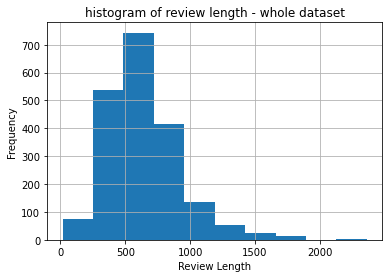

In [13]:
# histogram of review length - whole dataset
df_raw.loc[:, 'review_length'].hist()
plt.title('histogram of review length - whole dataset')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

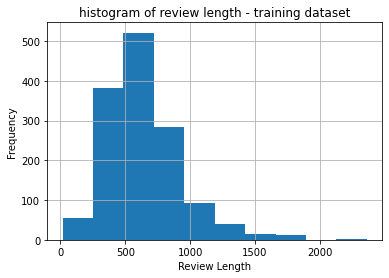

In [14]:
# histogram of review length - training dataset
df_raw.loc[df_raw[df_raw.file_no < 700].index, 'review_length'].hist()
plt.title('histogram of review length - training dataset')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

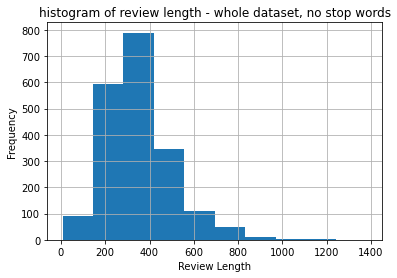

In [15]:
# histogram of review length - whole dataset - no stop words
df_raw.loc[:, 'review_length_non_sw'].hist()
plt.title('histogram of review length - whole dataset, no stop words')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

#### (b)-vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to rep- resent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [16]:
# tokenize training and testing text reviews, setting max words to 5000
# use text after removing stop words
tokenizer = keras.preprocessing.text.Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(df_raw_train.loc[:, 'cleaned_text_reviews_non_sw'])

X_train_tkn = tokenizer.texts_to_sequences(df_raw_train.loc[:, 'cleaned_text_reviews_non_sw'])
X_test_tkn = tokenizer.texts_to_sequences(df_raw_test.loc[:, 'cleaned_text_reviews_non_sw'])

#### (b)-viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [17]:
# select review length threshold L (70th percentile) based on training set reviews
max_length = int(df_raw_train.loc[:, 'review_length'].quantile(0.7))
print('review length threshold L at 70th percentile =', max_length)

max_length = int(df_raw_train.loc[:, 'review_length_non_sw'].quantile(0.7))
print('review length threshold L at 70th percentile (remove stop words) =', max_length)

review length threshold L at 70th percentile = 730
review length threshold L at 70th percentile (remove stop words) = 398


#### (b)-ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L

In [18]:
# truncate reviews longer than L
X_train_truncate = [i[:max_length] for i in X_train_tkn]
X_test_truncate = [i[:max_length] for i in X_test_tkn]

# zero-pad reviews shorter than L
X_train = keras.preprocessing.sequence.pad_sequences(X_train_truncate, padding = 'post', maxlen = max_length)
X_test = keras.preprocessing.sequence.pad_sequences(X_test_truncate, padding = 'post', maxlen = max_length)

In [19]:
# define y_train and y_test
y_train = df_raw_train.loc[:, 'class'].astype(int).values
y_test = df_raw_test.loc[:, 'class'].astype(int).values

## (c) Word Embeddings

#### (c)-i. One can use tokenized text as inputs to a deep neural network. However, a re- cent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.”4. Most deep learning modules (including Keras) provide a convenient way to convert positive integer rep- resentations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are inter- ested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document.5 If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.

In [20]:
# set seed
seed = 1
tf.random.set_seed(seed)

top_words = 5000
embedding_dim = 32

In [21]:
model_mlp = keras.models.Sequential()
model_mlp.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 398, 32)           160032    
                                                                 
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________


#### (c)-ii. Flatten the matrix of each document to a vector.

In [22]:
model_mlp.add(keras.layers.Flatten())
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 398, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 12736)             0         
                                                                 
Total params: 160,032
Trainable params: 160,032
Non-trainable params: 0
_________________________________________________________________


## (d) Multi-Layer Perceptron

#### (d)-i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [23]:
# add 3 dense hidden layers with 50 ReLUs each
model_mlp.add(keras.layers.Dropout(0.2))
model_mlp.add(keras.layers.Dense(50, activation = 'relu'))
model_mlp.add(keras.layers.Dropout(0.5))
model_mlp.add(keras.layers.Dense(50, activation = 'relu'))
model_mlp.add(keras.layers.Dropout(0.5))
model_mlp.add(keras.layers.Dense(50, activation = 'relu'))

# add 1 output layer with sigmoid function
model_mlp.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 398, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 12736)             0         
                                                                 
 dropout (Dropout)           (None, 12736)             0         
                                                                 
 dense (Dense)               (None, 50)                636850    
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

In [24]:
# train MLP with ADAM optimizer and binary cross entropy loss
model_mlp.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_mlp.fit(X_train, y_train, epochs = 2, batch_size = 10)

Epoch 1/2
140/140 [==============================] - 1s 4ms/step - loss: 0.6967 - accuracy: 0.5021
Epoch 2/2
140/140 [==============================] - 1s 4ms/step - loss: 0.6637 - accuracy: 0.6086


#### (d)-ii. Report the train and test accuracies of this model.

In [25]:
train_loss_mlp, train_accuracy_mlp = model_mlp.evaluate(X_train, y_train, verbose = False)
print("MLP - Training Accuracy: {:.4f}".format(train_accuracy_mlp))
test_loss_mlp, test_accuracy_mlp = model_mlp.evaluate(X_test, y_test, verbose = False)
print("MLP - Testing Accuracy:  {:.4f}".format(test_accuracy_mlp))

MLP - Training Accuracy: 0.8700
MLP - Testing Accuracy:  0.6367


> Using just 2 epochs give very low accuracy - train with more epochs and see the training loss curve in order to select a better number of epochs

#### train with a few more epochs and see accuracy graph

In [26]:
model_mlp_full = keras.models.Sequential()

# embed
model_mlp_full.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))
# flatten
model_mlp_full.add(keras.layers.Flatten())

# add 3 dense hidden layers with 50 ReLUs each
model_mlp_full.add(keras.layers.Dropout(0.2))
model_mlp_full.add(keras.layers.Dense(50, activation = 'relu'))
model_mlp_full.add(keras.layers.Dropout(0.5))
model_mlp_full.add(keras.layers.Dense(50, activation = 'relu'))
model_mlp_full.add(keras.layers.Dropout(0.5))
model_mlp_full.add(keras.layers.Dense(50, activation = 'relu'))

# add 1 output layer with sigmoid function
model_mlp_full.add(keras.layers.Dense(1, activation = 'sigmoid'))


In [27]:
# train MLP with ADAM optimizer and binary cross entropy loss
model_mlp_full.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
results_mlp = model_mlp_full.fit(X_train, y_train, epochs = 30, batch_size = 10)

Epoch 1/30
140/140 [==============================] - 1s 4ms/step - loss: 0.6960 - accuracy: 0.5279
Epoch 2/30
140/140 [==============================] - 1s 4ms/step - loss: 0.6648 - accuracy: 0.5893
Epoch 3/30
140/140 [==============================] - 1s 4ms/step - loss: 0.3644 - accuracy: 0.8429
Epoch 4/30
140/140 [==============================] - 1s 4ms/step - loss: 0.0499 - accuracy: 0.9850
Epoch 5/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0198 - accuracy: 0.9950
Epoch 6/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0093 - accuracy: 0.9964
Epoch 7/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 8/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0118 - accuracy: 0.9971
Epoch 9/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0049 - accuracy: 0.9986
Epoch 10/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0051 - accuracy: 0.9986

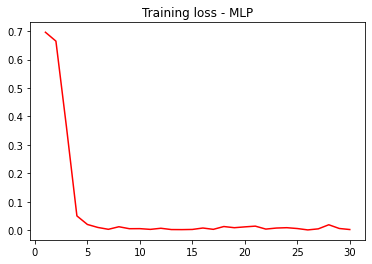

In [28]:
# plot training loss vs epochs

training_loss_mlp = results_mlp.history['loss']
epochs_mlp = range(1, len(training_loss_mlp) + 1)

plt.plot(epochs_mlp, training_loss_mlp, 'r')
plt.title('Training loss - MLP')
plt.show()

> plotting the curve between training loss and number of epochs show that there's an elbow at around 5 epochs, which also yielded almost zero training loss. Hence, we'll use 5 epochs to train the MLP once again.

In [29]:
# use 5 epochs to train
model_mlp_best = keras.models.Sequential()

# embed
model_mlp_best.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))
# flatten
model_mlp_best.add(keras.layers.Flatten())

# add 3 dense hidden layers with 50 ReLUs each
model_mlp_best.add(keras.layers.Dropout(0.2))
model_mlp_best.add(keras.layers.Dense(50, activation = 'relu'))
model_mlp_best.add(keras.layers.Dropout(0.5))
model_mlp_best.add(keras.layers.Dense(50, activation = 'relu'))
model_mlp_best.add(keras.layers.Dropout(0.5))
model_mlp_best.add(keras.layers.Dense(50, activation = 'relu'))

# add 1 output layer with sigmoid function
model_mlp_best.add(keras.layers.Dense(1, activation = 'sigmoid'))


In [30]:
# train MLP with ADAM optimizer and binary cross entropy loss - 5 epochs
model_mlp_best.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_mlp_best.fit(X_train, y_train, epochs = 5, batch_size = 10)

Epoch 1/5
140/140 [==============================] - 1s 4ms/step - loss: 0.6960 - accuracy: 0.5207
Epoch 2/5
140/140 [==============================] - 1s 4ms/step - loss: 0.6404 - accuracy: 0.6443
Epoch 3/5
140/140 [==============================] - 1s 4ms/step - loss: 0.2943 - accuracy: 0.8864
Epoch 4/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0441 - accuracy: 0.9879
Epoch 5/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0130 - accuracy: 0.9971


In [31]:
train_loss_mlp_best, train_accuracy_mlp_best = model_mlp_best.evaluate(X_train, y_train, verbose = False)
print("Best > MLP - Training Accuracy: {:.4f}".format(train_accuracy_mlp_best))
test_loss_mlp_best, test_accuracy_mlp_best = model_mlp_best.evaluate(X_test, y_test, verbose = False)
print("Best > MLP - Testing Accuracy:  {:.4f}".format(test_accuracy_mlp_best))

Best > MLP - Training Accuracy: 1.0000
Best > MLP - Testing Accuracy:  0.7150


> It can be seen that the testing accuracy improves to 71.5% on MLP with 5 epochs

## (e) One-Dimensional Convolutional Neural Network
Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

#### (e)-i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [32]:
model_cnn = keras.models.Sequential()

# word embedding
model_cnn.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))

# add 1 Conv1D layer
model_cnn.add(keras.layers.Conv1D(filters = 32, kernel_size = 3))

# add 1D max pooling layer
model_cnn.add(keras.layers.MaxPooling1D(pool_size = 2, strides = 2))

# flatten
model_cnn.add(keras.layers.Flatten())

# add 3 dense hidden layers with 50 ReLUs each
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Dense(50, activation = 'relu'))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Dense(50, activation = 'relu'))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Dense(50, activation = 'relu'))

# add 1 output layer with sigmoid function
model_cnn.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 398, 32)           160032    
                                                                 
 conv1d (Conv1D)             (None, 396, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 198, 32)          0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 6336)              0         
                                                                 
 dropout_9 (Dropout)         (None, 6336)              0         
                                                                 
 dense_12 (Dense)            (None, 50)                316850    
                                                      

In [33]:
# train CNN with ADAM optimizer and binary cross entropy loss
model_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_cnn.fit(X_train, y_train.reshape(-1,1), epochs = 2, batch_size = 10)

Epoch 1/2
140/140 [==============================] - 1s 5ms/step - loss: 0.6971 - accuracy: 0.5086
Epoch 2/2
140/140 [==============================] - 1s 5ms/step - loss: 0.6877 - accuracy: 0.5314


> Similarly to normal MLP in (d), using just 2 epochs give poor accuracy. Will try in the next step to see if increasing number of epochs improve performance 

#### (e)-ii. Report the train and test accuracies of this model.

In [34]:
train_loss_cnn, train_accuracy_cnn = model_cnn.evaluate(X_train, y_train.reshape(-1,1), verbose = False)
print("CNN - Training Accuracy: {:.4f}".format(train_accuracy_cnn))
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test.reshape(-1,1), verbose = False)
print("CNN - Testing Accuracy:  {:.4f}".format(test_accuracy_cnn))

CNN - Training Accuracy: 0.7536
CNN - Testing Accuracy:  0.5700


#### try more number of epochs

In [35]:
model_cnn_full = keras.models.Sequential()

# word embedding
model_cnn_full.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))

# add 1 Conv1D layer
model_cnn_full.add(keras.layers.Conv1D(filters = 32, kernel_size = 3))

# add 1D max pooling layer
model_cnn_full.add(keras.layers.MaxPooling1D(pool_size = 2, strides = 2))

# flatten
model_cnn_full.add(keras.layers.Flatten())

# add 3 dense hidden layers with 50 ReLUs each
model_cnn_full.add(keras.layers.Dropout(0.2))
model_cnn_full.add(keras.layers.Dense(50, activation = 'relu'))
model_cnn_full.add(keras.layers.Dropout(0.5))
model_cnn_full.add(keras.layers.Dense(50, activation = 'relu'))
model_cnn_full.add(keras.layers.Dropout(0.5))
model_cnn_full.add(keras.layers.Dense(50, activation = 'relu'))

# add 1 output layer with sigmoid function
model_cnn_full.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [36]:
# train MLP with ADAM optimizer and binary cross entropy loss
model_cnn_full.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
results_cnn = model_mlp_full.fit(X_train, y_train.reshape(-1,1), epochs = 30, batch_size = 10)

Epoch 1/30
140/140 [==============================] - 1s 4ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 2/30
140/140 [==============================] - 1s 5ms/step - loss: 3.1510e-04 - accuracy: 1.0000
Epoch 3/30
140/140 [==============================] - 1s 4ms/step - loss: 6.4898e-04 - accuracy: 0.9993
Epoch 4/30
140/140 [==============================] - 1s 5ms/step - loss: 2.5805e-05 - accuracy: 1.0000
Epoch 5/30
140/140 [==============================] - 1s 5ms/step - loss: 2.1335e-04 - accuracy: 1.0000
Epoch 6/30
140/140 [==============================] - 1s 5ms/step - loss: 1.0995e-04 - accuracy: 1.0000
Epoch 7/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0052 - accuracy: 0.9979
Epoch 8/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0058 - accuracy: 0.9986
Epoch 9/30
140/140 [==============================] - 1s 5ms/step - loss: 0.0025 - accuracy: 0.9986
Epoch 10/30
140/140 [==============================] - 1s 5ms/step - loss: 0.024

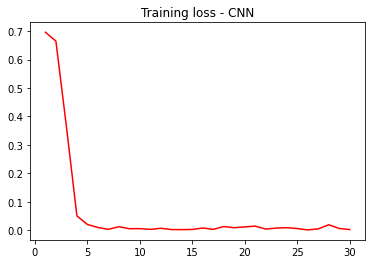

In [37]:
# plot training loss vs epochs

training_loss_cnn = results_mlp.history['loss']
epochs_cnn = range(1, len(training_loss_cnn) + 1)

plt.plot(epochs_cnn, training_loss_cnn, 'r')
plt.title('Training loss - CNN')
plt.show()

> It can be seen from the curve that the elbow is around 5 epochs where training error almost reaches 0. Will use 5 epochs to retrain the model

#### train the model again with 5 epochs

In [38]:
model_cnn_best = keras.models.Sequential()

# word embedding
model_cnn_best.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))

# add 1 Conv1D layer
model_cnn_best.add(keras.layers.Conv1D(filters = 32, kernel_size = 3))

# add 1D max pooling layer
model_cnn_best.add(keras.layers.MaxPooling1D(pool_size = 2, strides = 2))

# flatten
model_cnn_best.add(keras.layers.Flatten())

# add 3 dense hidden layers with 50 ReLUs each
model_cnn_best.add(keras.layers.Dropout(0.2))
model_cnn_best.add(keras.layers.Dense(50, activation = 'relu'))
model_cnn_best.add(keras.layers.Dropout(0.5))
model_cnn_best.add(keras.layers.Dense(50, activation = 'relu'))
model_cnn_best.add(keras.layers.Dropout(0.5))
model_cnn_best.add(keras.layers.Dense(50, activation = 'relu'))

# add 1 output layer with sigmoid function
model_cnn_best.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [39]:
# train CNN with ADAM optimizer and binary cross entropy loss
model_cnn_best.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_cnn_best.fit(X_train, y_train.reshape(-1,1), epochs = 5, batch_size = 10)

Epoch 1/5
140/140 [==============================] - 1s 6ms/step - loss: 0.6955 - accuracy: 0.5043
Epoch 2/5
140/140 [==============================] - 1s 6ms/step - loss: 0.6846 - accuracy: 0.5707
Epoch 3/5
140/140 [==============================] - 1s 5ms/step - loss: 0.4624 - accuracy: 0.7821
Epoch 4/5
140/140 [==============================] - 1s 6ms/step - loss: 0.1408 - accuracy: 0.9579
Epoch 5/5
140/140 [==============================] - 1s 6ms/step - loss: 0.0313 - accuracy: 0.9893


In [40]:
train_loss_cnn, train_accuracy_cnn = model_cnn_best.evaluate(X_train, y_train.reshape(-1,1), verbose = False)
print("Best > CNN - Training Accuracy: {:.4f}".format(train_accuracy_cnn))
test_loss_cnn, test_accuracy_cnn = model_cnn_best.evaluate(X_test, y_test.reshape(-1,1), verbose = False)
print("Best > CNN - Testing Accuracy:  {:.4f}".format(test_accuracy_cnn))

Best > CNN - Training Accuracy: 1.0000
Best > CNN - Testing Accuracy:  0.8083


> Similarly to MLP, it can be seen that increasing number of epochs improved testing accuracy to 80.8%

## (f) Long Short-Term Memory Recurrent Neural Network
The structure of the LSTM we are going to use is shown in the following figure

#### (f)-i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [41]:
model_lstm = keras.models.Sequential()

# word embedding
model_lstm.add(keras.layers.Embedding(input_dim = top_words + 1, 
                           output_dim = embedding_dim, 
                           input_length = max_length))

# add LSTM
model_lstm.add(keras.layers.LSTM(units = 32, dropout = 0.2, return_sequences = True))

model_lstm.add(keras.layers.Flatten())

# add 3 dense hidden layers with 50 ReLUs each
model_lstm.add(keras.layers.Dropout(0.2))
model_lstm.add(keras.layers.Dense(256, activation = 'relu'))

# add 1 output layer with sigmoid function
model_lstm.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 398, 32)           160032    
                                                                 
 lstm (LSTM)                 (None, 398, 32)           8320      
                                                                 
 flatten_6 (Flatten)         (None, 12736)             0         
                                                                 
 dropout_18 (Dropout)        (None, 12736)             0         
                                                                 
 dense_24 (Dense)            (None, 256)               3260672   
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,429,281
Trainable params: 3,429,281
No

In [42]:
# train LSTM with ADAM optimizer and binary cross entropy loss
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_lstm.fit(X_train, y_train.reshape(-1,1), epochs = 10, batch_size = 10)

Epoch 1/10
140/140 [==============================] - 11s 71ms/step - loss: 0.6505 - accuracy: 0.5914
Epoch 2/10
140/140 [==============================] - 10s 68ms/step - loss: 0.2978 - accuracy: 0.8786
Epoch 3/10
140/140 [==============================] - 9s 66ms/step - loss: 0.0597 - accuracy: 0.9793
Epoch 4/10
140/140 [==============================] - 9s 63ms/step - loss: 0.0080 - accuracy: 0.9964
Epoch 5/10
140/140 [==============================] - 9s 64ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 6/10
140/140 [==============================] - 10s 69ms/step - loss: 0.0103 - accuracy: 0.9964
Epoch 7/10
140/140 [==============================] - 10s 68ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 8/10
140/140 [==============================] - 10s 73ms/step - loss: 0.0038 - accuracy: 0.9986
Epoch 9/10
140/140 [==============================] - 9s 65ms/step - loss: 4.2714e-04 - accuracy: 1.0000
Epoch 10/10
140/140 [==============================] - 9s 63ms/step - loss: 5.5753

> It can be seen that using just 10 epochs already reach the training accuracy of 100%. Therefore, 10 epochs will be used for this LSTM model as there's a risk of overfitting if the number of epochs is increased further

#### (f)-ii. Report the train and test accuracies of this model.

In [43]:
train_loss_lstm, train_accuracy_lstm = model_lstm.evaluate(X_train, y_train.reshape(-1,1), verbose = False)
print("LSTM - Training Accuracy: {:.4f}".format(train_accuracy_lstm))
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test.reshape(-1,1), verbose = False)
print("LSTM - Testing Accuracy:  {:.4f}".format(test_accuracy_lstm))

LSTM - Training Accuracy: 1.0000
LSTM - Testing Accuracy:  0.8200


> <b>Performance Summary</b>
> - Training MLP for this sentiment analysis, the best accuracy achieved (using 5 epochs) is at 71.5%
> - With CNN and LSTM layers included, the testing accuracy improved from the previous MLP. CNN is able to achieved 80.8% test accuracy while LSTM is able to achieve 82.0% accuracy.